In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from geopy.distance import geodesic
import sklearn.feature_selection
from sklearn.model_selection import train_test_split
import pickle
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#train_path = '/content/drive/My Drive/Colab Notebooks/train.csv'
train_path = 'train.csv'

In [3]:
train = pd.read_csv(train_path, nrows=1_000_000) #we don't select all rows, since it is a big dataset
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

## Pre-processing (denoising data) and feature engineering

In [6]:
train['key'] = pd.to_datetime(train['key'])
train.dtypes

key                  datetime64[ns]
fare_amount                 float64
pickup_datetime              object
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [7]:
#add features related with datetime
train['weekday'] = train['key'].dt.dayofweek

train['year']=train['key'].dt.year
train['month']=train['key'].dt.month
train['day']=train['key'].dt.day
train['hour']=train['key'].dt.hour
#train['minute']=train['key'].dt.minute #needed?
#train['second']=train['key'].dt.second

In [8]:
#check if there are some NaN values
train.columns[train.isna().any()].tolist()

['dropoff_longitude', 'dropoff_latitude']

In [9]:
#we drop these values given that the data set is quite big
#original rows: 1_000_000
train.dropna(inplace=True)
train.shape[0]

999990

In [10]:
#drop duplicates
train.drop_duplicates(keep = 'first', inplace = True)
train.shape[0]

999990

In [11]:
train.describe()
#check the describe to see if their values make sense

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour
count,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000
mean,11.347953,-72.526699,39.929040,-72.527860,39.919954,1.684941,3.039870,2011.741103,6.267841,15.697996,13.509463
std,9.821790,12.057778,7.626087,11.324494,8.201418,1.323907,1.949966,1.860761,3.436230,8.682472,6.513855
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000,1.000000,2010.000000,3.000000,8.000000,9.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000,3.000000,2012.000000,6.000000,16.000000,14.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000,5.000000,2013.000000,9.000000,23.000000,19.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000,6.000000,2015.000000,12.000000,31.000000,23.000000


In [12]:
#based on these descriptors, we can at first sight already remove some outliers:
#1) Latitudes range from -90 to 90. Longitudes range from -180 to 180.
#2) passengers in a taxi, up to 6 (icnluding suvs) https://ride.guru/lounge/p/how-many-people-can-ride-in-a-cab 
#leave drives of 0 passengers in case documents are transported?
#3) fare has to be positive value, over 2.50$? (that seems to be the initial charge) https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page
#also fare now seems too high (500) and the variance is pretty hight too. so we cut the max fare now

#4) new york city actually has the following bounding box of coordinates (https://boundingbox.klokantech.com/)
eastlimit_longitude=-73.700181
southlimit_latitude =40.47739894
westlimit_longitude=-74.25909
northlimit_latitude=40.916178         
                                                                                                               
train = train[ (train.pickup_longitude >= westlimit_longitude) & (train.pickup_longitude <= eastlimit_longitude) & \
              (train.dropoff_longitude >= westlimit_longitude) & (train.dropoff_longitude <= eastlimit_longitude) & \
              (train.pickup_latitude >= southlimit_latitude ) & (train.pickup_latitude <= northlimit_latitude) & \
              (train.dropoff_latitude >= southlimit_latitude) & (train.dropoff_latitude <= northlimit_latitude) & \
              (train.passenger_count<= 6) & \
              (train.fare_amount >= 2.50) ]                                                                              

#train = train[ (train.pickup_longitude >= -180) & (train.pickup_longitude <= 180) & \
#              (train.dropoff_longitude >= -180) & (train.dropoff_longitude <= 180) & \
#              (train.pickup_latitude >= -90) & (train.pickup_latitude <= 90) & \
#              (train.dropoff_latitude >= -90) & (train.dropoff_latitude <= 90) & \
#              (train.passenger_count<= 6) & \
#              (train.fare_amount > 2.50)  ]
    


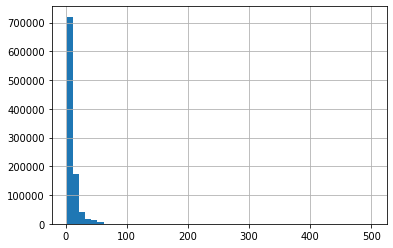

In [13]:
train.fare_amount.hist(bins=50)

In [14]:
train = train[ (train.fare_amount < 100)]

In [15]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour
count,977645.000000,977645.000000,977645.000000,977645.000000,977645.000000,977645.000000,977645.000000,977645.000000,977645.000000,977645.000000,977645.000000
mean,11.266474,-73.975504,40.750870,-73.974565,40.751213,1.685273,3.039712,2011.739611,6.268954,15.692850,13.509751
std,9.295219,0.034370,0.026836,0.033850,0.030715,1.307981,1.949785,1.863163,3.437980,8.683036,6.510818
min,2.500000,-74.258821,40.482543,-74.258579,40.479537,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000
25%,6.000000,-73.992275,40.736587,-73.991571,40.735597,1.000000,1.000000,2010.000000,3.000000,8.000000,9.000000
50%,8.500000,-73.982092,40.753401,-73.980605,40.753859,1.000000,3.000000,2012.000000,6.000000,16.000000,14.000000
75%,12.500000,-73.968367,40.767541,-73.965390,40.768394,2.000000,5.000000,2013.000000,9.000000,23.000000,19.000000
max,99.750000,-73.700438,40.913110,-73.700390,40.916035,6.000000,6.000000,2015.000000,12.000000,31.000000,23.000000


In [16]:
#maybe convert time (hours and minutes) to circular, given that then the correlation may be more easily seen
#seconds_in_day = 24*60*60

#train['full_time'] = train.hour*60*60 + train.minute*60 + train.second #time of the day in seconds
#train['sin_time'] = np.sin(2*np.pi*train.full_time/seconds_in_day)
#train['cos_time'] = np.cos(2*np.pi*train.full_time/seconds_in_day)
#train.drop('full_time', axis=1, inplace=True)

#note: checked that these 2 feats are computed ok (proper ranges)

In [20]:
#Instead of doing Harvestine distance (that assumes Earth is a sphere), here Vincenty distance is used,
#which employs more accurate ellipsoidal models

# (latitude, longitude) reminder
train ['distance'] = train.apply(lambda x: geodesic((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).kilometers, axis = 1)

In [ ]:
train['distance'].describe()

In [ ]:
train.describe().loc[['min','max']]

In [22]:
#related with distances, we remove the following cases:
#A) distance is 0, and the coordinates of pick up and dropoff are different (so no possible then for round trip
# or for the taxi waiting the customer)
#B) distance is not 0, but coordinates of pick up and dropoff are same
idx_distCaseA = train.index[ (train.distance == 0) &  ( (train.pickup_latitude != train.dropoff_latitude ) | \
                                                         (train.pickup_longitude != train.dropoff_longitude)) ]

idx_distCaseB = train.index[ (train.distance != 0) &  ( (train.pickup_latitude == train.dropoff_latitude ) & \
                                                         (train.pickup_longitude == train.dropoff_longitude)) ]


In [24]:
#idx_distCaseB and idx_distCaseA seems empty, but there are distances of 0 (10156 rows) 
#so those have same pickup and dropoff coordinates 
idx_distCaseB

Int64Index([], dtype='int64')

In [26]:

train[train.distance == 0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour,distance
105,2009-03-25 00:08:52.000000100,52.0,2009-03-25 00:08:52 UTC,-74.035839,40.747320,-74.035839,40.747320,1,2,2009,3,25,0,0.0
191,2014-01-08 21:55:58.000000600,6.5,2014-01-08 21:55:58 UTC,-73.998488,40.726303,-73.998488,40.726303,1,2,2014,1,8,21,0.0
270,2012-08-25 01:53:42.000000500,7.5,2012-08-25 01:53:42 UTC,-73.995892,40.746454,-73.995892,40.746454,1,5,2012,8,25,1,0.0
290,2009-12-14 12:33:00.000000750,6.9,2009-12-14 12:33:00 UTC,-73.982432,40.745747,-73.982432,40.745747,1,0,2009,12,14,12,0.0
396,2014-03-12 18:12:44.000000600,12.0,2014-03-12 18:12:44 UTC,-73.844904,40.736318,-73.844904,40.736318,1,2,2014,3,12,18,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999727,2012-04-02 18:23:00.000000700,6.5,2012-04-02 18:23:00 UTC,-73.992938,40.766027,-73.992938,40.766027,5,0,2012,4,2,18,0.0
999827,2010-11-19 10:34:00.000000440,4.9,2010-11-19 10:34:00 UTC,-73.953462,40.779228,-73.953462,40.779228,5,4,2010,11,19,10,0.0
999931,2012-03-05 22:22:00.000000181,6.9,2012-03-05 22:22:00 UTC,-73.970005,40.713008,-73.970005,40.713008,5,0,2012,3,5,22,0.0
999988,2011-05-14 07:21:00.000000140,25.3,2011-05-14 07:21:00 UTC,-73.937393,40.757975,-73.937393,40.757975,5,5,2011,5,14,7,0.0


In [27]:
#log transform for distance helps
train['distance_log'] = train['distance'].transform(lambda x: np.log(x+sys.float_info.epsilon))
train.shape

(977645, 15)

In [ ]:
#there are some flat rates on trips from/to some of the airports in NY (JFK, LaGuardia, Newark) so we add features of
#distances from/to these airports
# coordinates from https://get-direction.com
jfk_latitude = 40.644538879
jfk_longitude = -73.795356750
laguardia_latitude = 40.774009705
laguardia_longitude =-73.872497559
newark_latitude = 40.692878723
newark_longitude = -74.185447693

train ['pickup_distance_jfk'] = train.apply(lambda x: geodesic((x['pickup_latitude'], x['pickup_longitude']), (jfk_latitude, jfk_longitude)).kilometers, axis = 1)
train ['pickup_distance_laguardia'] = train.apply(lambda x: geodesic((x['pickup_latitude'], x['pickup_longitude']), (laguardia_latitude, laguardia_longitude)).kilometers, axis = 1)
train ['pickup_distance_newark'] = train.apply(lambda x: geodesic((x['pickup_latitude'], x['pickup_longitude']), (newark_latitude, newark_longitude)).kilometers, axis = 1)
train ['dropoff_distance_jfk'] = train.apply(lambda x: geodesic((x['dropoff_latitude'], x['dropoff_longitude']), (jfk_latitude, jfk_longitude)).kilometers, axis = 1)
train ['dropoff_distance_laguardia'] = train.apply(lambda x: geodesic((x['dropoff_latitude'], x['dropoff_longitude']), (laguardia_latitude, laguardia_longitude)).kilometers, axis = 1)
train ['dropoff_distance_newark'] = train.apply(lambda x: geodesic((x['dropoff_latitude'], x['dropoff_longitude']), (newark_latitude, newark_longitude)).kilometers, axis = 1)


## Data visualization (exploratory analysis)

In [ ]:
#check distributions of all the features
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train.hist(ax = ax, bins=50)


In [ ]:
corr_pearson = train.corr(method='pearson')
mask = np.zeros_like(corr_pearson, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

In [ ]:
fig4, ax4 = plt.subplots(figsize=(16, 10))
sns.heatmap(corr_pearson, mask=mask, cmap='RdBu_r', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},vmin=-1)

In [ ]:
#visualizer = FeatureCorrelation( method='mutual_info-classification', feature_names=train_out.columns, sort=True)
X = train.drop(['fare_amount','key','pickup_datetime'],axis=1, inplace=False).to_numpy()
Y = train.fare_amount.to_numpy()
#lab_enc = sklearn.preprocessing.LabelEncoder()
#Y_encoded = lab_enc.fit_transform(Y)

#mutual information has too expensive computationally to run for all data, so we just take 
X = X[1:100000,:]
Y = Y[1:100000]

feature_MIscores = sklearn.feature_selection.mutual_info_regression(X, Y)

In [ ]:
feature_MIscores.shape

#plot also the fare vs the date (year), and maybe check as hypothesis if there is a positive correlation between year and fare

In [ ]:
feats_labels = train.drop(['fare_amount','key','pickup_datetime'],axis=1, inplace=False).columns
#print(feats_labels)
index = np.arange(len(feats_labels))
plt.figure(figsize=(10,10))
plt.barh(index, feature_MIscores)
plt.xlabel('mutual information score', fontsize=20)
plt.yticks(index, feats_labels, fontsize=10, rotation=30)

In [ ]:
#sns.pairplot(train, y_vars=['fare_amount'], x_vars=['distance', 'distance_log', 'hour','day','month','year','weekday','passenger_count','dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude'])

In [ ]:
sns.scatterplot(x="distance", y="fare_amount", data=train)

In [ ]:
#there is also a kind of straight line, that can be explained by the flat rates used for taxi rides from airport
 #"Taxis at JFK Airport charge a flat fare of $52 for trips between the airport and Manhattan." 
#https://www.jfkairport.com/to-from-airport/taxi-car-and-van-service
sns.scatterplot(x="distance_log", y="fare_amount", data=train)

In [ ]:
#using hex bins because regular scatter plot does not work (too many points)
sns.jointplot(x="distance", y="fare_amount", data=train, kind='reg',joint_kws={'line_kws':{'color':'cyan'}})

In [ ]:
#using hex bins because regular scatter plot does not work (too many points)
#easier to see with dostance_log since the scale is shrunk
sns.jointplot(x="distance", y="fare_amount", data=train, kind='hex')

In [ ]:
#TODO: maybe also plot histograms grouping by day, or by hour, to see what times are more common, and see if the fair is similar for 

In [ ]:
#TODO:maybe a heat map of the fares would be interesting, doing a geomap, maybe use plotly?

In [ ]:
#TODO: maybe employ clustering to get some extra information of the data, like outliers? 

## Split of training data (train + validation)

In [ ]:
train2, val = train_test_split(train, test_size=0.3)

In [ ]:
train.shape

In [ ]:
train2.shape

In [ ]:
train.columns

In [ ]:
val.shape

## Modeling 
### (Comparison of several regression models, plus a dummy model as baseline)

In [ ]:
X_train = train2[['year','distance_log','pickup_distance_jfk','pickup_distance_laguardia','pickup_distance_newark',\
                  'dropoff_distance_jfk','dropoff_distance_laguardia','dropoff_distance_newark']]
y_train = train2[['fare_amount']]

X_val = val[['year','distance_log','pickup_distance_jfk','pickup_distance_laguardia','pickup_distance_newark',\
                  'dropoff_distance_jfk','dropoff_distance_laguardia','dropoff_distance_newark']]
y_val = val[['fare_amount']]

### Dummy model

In [ ]:
from time import time
dummy_regr = DummyRegressor(strategy="mean")
t0_dummy=time()
dummy_regr.fit(X_train, y_train)
print("Dummy model regression, training time:" + str(round(time()-t0_dummy, 3)) + "s")
print(dummy_regr)


In [ ]:
y_valPred_dummy = dummy_regr.predict(X_val)
y_trainPred_dummy = dummy_regr.predict(X_train)

In [ ]:
#R2 is the proportion of the variance in the dependent variable that is predictable from the independent
#variable(s).

r2_val_dummy = r2_score(y_val, y_valPred_dummy)
r2_train_dummy = r2_score(y_train, y_trainPred_dummy)

print('Dummy model- training, R2:' + str(r2_train_dummy))
print('Dummy model- validation, R2:' + str(r2_val_dummy))


In [ ]:
mse_val_dummy = mean_squared_error(y_val, y_valPred_dummy)
mse_train_dummy = mean_squared_error(y_train, y_trainPred_dummy)

print('Dummy model - training, MSE:' + str(mse_train_dummy))
print('Dummy model - validation, MSE:' + str(mse_val_dummy))

### Linear regression

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

#use same scaler for both, based on X_train data
X_trainNorm = scaler.transform(X_train)
X_valNorm = scaler.transform(X_val)

In [ ]:
# create linear regression model
linRegr = linear_model.LinearRegression()
print(linRegr)

In [ ]:
# train the model with training data

t0_linR=time()
linRegr.fit(X_trainNorm, y_train)
print("Linear regression, training time:" + str(round(time()-t0_linR, 3)) + "s")
print(linRegr)

In [ ]:
y_valPred_linReg = linRegr.predict(X_valNorm) #to check validation error measures
y_trainPred_linReg = linRegr.predict(X_trainNorm) #to check training error measures

In [ ]:
r2_val_linReg = r2_score(y_val, y_valPred_linReg)
r2_train_linReg = r2_score(y_train, y_trainPred_linReg)

print('Linear regression - training, R2:' + str(r2_train_linReg))
print('Linear regression - validation, R2:' + str(r2_val_linReg))


In [ ]:
mse_val_linReg = mean_squared_error(y_val, y_valPred_linReg)
mse_train_linReg = mean_squared_error(y_train, y_trainPred_linReg)

print('Linear regression - training, MSE:' + str(mse_train_linReg))
print('Linear regression - validation, MSE:' + str(mse_val_linReg))


### Linear regression with Lasso regularization (i.e. feature selection)

In [ ]:
train2.columns

In [ ]:
X_train_lasso = train2.drop(['fare_amount','key','pickup_datetime','distance'],axis=1, inplace=False)
y_train_lasso = train2[['fare_amount']]

X_val_lasso = val.drop(['fare_amount','key','pickup_datetime','distance'],axis=1, inplace=False)
y_val_lasso = val[['fare_amount']]

In [ ]:
X_train_lasso.shape

In [ ]:
y_train_lasso.shape

In [ ]:
scaler_lasso = StandardScaler()
scaler_lasso.fit(X_train_lasso)

#use same scaler for both, based on X_train_lasso data
X_trainLassoNorm = scaler_lasso.transform(X_train_lasso)
X_valLassoNorm = scaler_lasso.transform(X_val_lasso)

In [ ]:
lassoReg = linear_model.LassoCV()
t0_linRLasso=time()
lassoReg.fit(X_trainLassoNorm, y_train_lasso.values.ravel())
print("Linear regression with Lasso reg., training time:" + str(round(time()-t0_linRLasso, 3)) + "s")
print(lassoReg)

In [ ]:
y_valPred_lassoReg = lassoReg.predict(X_valLassoNorm)
y_trainPred_lassoReg = lassoReg.predict(X_trainLassoNorm)

In [ ]:
r2_val_lassoReg = r2_score(y_val_lasso, y_valPred_lassoReg)
r2_train_lassoReg = r2_score(y_train_lasso, y_trainPred_lassoReg)

print('Linear regression with Lasso reg. - training, R2:' + str(r2_train_lassoReg))
print('Linear regression with Lasso reg. - validation, R2:' + str(r2_val_lassoReg))

In [ ]:
mse_val_lassoReg = mean_squared_error(y_val_lasso, y_valPred_lassoReg)
mse_train_lassoReg = mean_squared_error(y_train_lasso, y_trainPred_lassoReg)

print('Linear regression with Lasso reg. - training, MSE:' + str(mse_train_lassoReg))
print('Linear regression with Lasso reg. - validation, MSE:' + str(mse_val_lassoReg))

In [ ]:
#TODO: include a plotbar showing the weights obtained

### Random forest regression

Decision trees can deal with non-linearity relationships between independent variables and the dependent variable (fare_amount), unlike linear regressors.

In [ ]:
randFor = RandomForestRegressor()

#decisions trees don't need normalized data since they don't assume any distribution

t0_randFor=time()
randFor.fit(X_train_lasso, y_train_lasso.values.ravel())
print("Random forest regression, training time:" + str(round(time()-t0_randFor, 3)) + "s")
print(randFor)

In [ ]:
y_valPred_randFor = randFor.predict(X_val_lasso)
y_trainPred_randFor = randFor.predict(X_train_lasso)

In [ ]:
r2_val_randFor = r2_score(y_val_lasso, y_valPred_randFor)
r2_train_randFor = r2_score(y_train_lasso, y_trainPred_randFor)

print('Random forest regression - training, R2:' + str(r2_train_randFor))
print('Random forest regression - validation, R2:' + str(r2_val_randFor))

In [ ]:
mse_val_randFor = mean_squared_error(y_val_lasso, y_valPred_randFor)
mse_train_randFor = mean_squared_error(y_train_lasso, y_trainPred_randFor)

print('Random forest regression - training, MSE:' + str(mse_train_randFor))
print('Random forest regression - validation, MSE:' + str(mse_val_randFor))

In [ ]:
#TODO: if possible, include a plotbar showing the feature importances (I think they can be extracted from the trained model)

### XGBoost regression

With this approach with reduce not only variance (as in random forests) but also the bias.
It has also regularization to avoid overfitting.

In [ ]:
# https://datascience.stackexchange.com/questions/23789/why-do-we-need-xgboost-and-random-forest
xgbr = xgb.XGBRegressor(objective ='reg:squarederror')  #objective changed based on warning: "reg:linear is now deprecated in favor of reg:squarederror."
print(xgbr)

In [ ]:
#again here, using decision trees, so no need 

t0_xgbr=time()
xgbr.fit(X_train_lasso, y_train_lasso.values.ravel())
print("XGBoost regression, training time:" + str(round(time()-t0_xgbr, 3)) + "s")
print(xgbr)

filename = 'XGBoost_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
y_valPred_xgbr = xgbr.predict(X_val_lasso)
y_trainPred_xgbr = xgbr.predict(X_train_lasso)

In [ ]:
r2_val_xgbr = r2_score(y_val_lasso, y_valPred_xgbr)
r2_train_xgbr = r2_score(y_train_lasso, y_trainPred_xgbr)

print('XGBoost regression - training, R2:' + str(r2_train_xgbr))
print('XGBoost regression - validation, R2:' + str(r2_val_xgbr))

In [ ]:
mse_val_xgbr = mean_squared_error(y_val_lasso, y_valPred_xgbr)
mse_train_xgbr = mean_squared_error(y_train_lasso, y_trainPred_xgbr)

print('XGBoost regression - training, MSE:' + str(mse_train_xgbr))
print('XGBoost forest regression - validation, MSE:' + str(mse_val_xgbr))

- #### XGBoost with parameter tuning

In [ ]:
#https://www.kaggle.com/omarito/gridsearchcv-xgbregressor-0-556-lb
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
#https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [ ]:
# Parameters that are going to be tuned are those given by an :
params ={}
params = {
    'max_depth': [3,5,7,9],
    'min_child_weight': [1,3,5],
    'learning_rate': [0.05,0.1,0.3],
    'subsample': [1],
    'colsample_bytree': [1],
    # Other parameters
    'objective': ['reg:squarederror'],
}
#num_boost_round = 999

In [ ]:
# initializing XGBoost and GridSearchCV

k=10 10-folding
xgb_regr_tuning = xgb.XGBRegressor() 
xgbr_grid = GridSearchCV(xgb_regr_tuning, params, cv=k, scoring='neg_mean_squared_error')

In [ ]:
#we use just a subset of the values, otherwise it takes too much time 
#(also, batches will be smaller, which may be better for results in the end)
X_train_grid = X_train_lasso.head(300_000)
y_train_grid = y_train_lasso.head(300_000)

t0_xgbrGrid=time()
grid_result = xgbr_grid.fit(X_train_grid, y_train_grid.values.ravel())
print("XGBoost grid search tuning, time:" + str(round(time()-t0_xgbrGrid, 3)) + "s")
print(xgbr_grid)

filename = 'XGBoostGrid_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
best_params = grid_result.best_params_
params['max_depth']=best_params['max_depth']
params['min_child_weight']=best_params['min_child_weight']
params['learning_rate']=best_params['learning_rate']

tuned_xgbr = xgb.XGBRegressor(params)
t0_xgbrGrid=time()
tuned_xgbr.fit(X_train_lasso, y_train_lasso.values.ravel())
print("XGBoost regression with tuning, training time:" + str(round(time()-t0_xgbrGrid, 3)) + "s")
print(xgbr_grid)

filename = 'XGBoostTuned_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
y_valPred_xgbrGrid = xgbr_grid.predict(X_val_lasso)
y_trainPred_xgbrGrid = xgbr_grid.predict(X_train_lasso)

In [ ]:
r2_val_xgbrGrid = r2_score(y_val_lasso, y_valPred_xgbrGrid)
r2_train_xgbrGrid = r2_score(y_train_lasso, y_trainPred_xgbrGrid)

print('XGBoost regression, with tuning - training, R2:' + str(r2_train_xgbrGrid))
print('XGBoost regression, with tuning - validation, R2:' + str(r2_val_xgbrGrid))

In [ ]:
mse_val_xgbrGrid = mean_squared_error(y_val_lasso, y_valPred_xgbrGrid)
mse_train_xgbrGrid = mean_squared_error(y_train_lasso, y_trainPred_xgbrGrid)

print('XGBoost regression - training, MSE:' + str(mse_train_xgbrGrid))
print('XGBoost forest regression - validation, MSE:' + str(mse_val_xgbrGrid))

In [ ]:
#been on end of notebook running
import os
duration = 1  # seconds
freq = 400  # Hz
#os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))